In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'sample_submission.csv', 'train_labels.csv', 'train']


In [2]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import os
from torchvision.utils import save_image
import argparse
from torchvision.datasets import ImageFolder, CIFAR10
from torchvision.models import vgg16
from torch.nn import Conv2d, MaxPool2d, ReLU
from torchvision.models import resnet34
from torch.utils.data import SubsetRandomSampler
import torch.nn.functional as F
from PIL import Image
from torch.optim import Adam, SGD

num_epochs = 40
batch_size = 128
learning_rate = 1e-4
normalize = transforms.Normalize(mean=[0.7033, 0.5467, 0.6972],
                                     std=[0.1579, 0.1778, 0.1401])

In [3]:
def train(model, dataloader, epoch, optimizer):
    for i, (images, targets) in enumerate(dataloader):
        images = images.cuda()
        targets = targets.cuda()
        optimizer.zero_grad()
        output = model(images)
        loss = F.cross_entropy(output, targets)
        loss.backward()
        optimizer.step()
        if i % 30 == 0:
            print('epoch[%d], loss:%f, acc:%f' % (epoch, loss.item(), (output.argmax(dim=1) == targets).int().sum().item() / len(targets)))

In [4]:
class ClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform):
        super(ClassificationDataset, self).__init__()
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # get the image as PIL Image:
        img = Image.open('../input/train/' + df['id'].tolist()[idx] + '.tif')
        img = self.transform(img)
        target = int(df['label'].tolist()[idx])
        return img, target

In [5]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

In [6]:
df = pd.read_csv('../input/train_labels.csv')
df = df[:10000]

# optional, randomly flip the label with 50% prob:
labels = np.array(df['label'])
for i, label in enumerate(labels):
    if np.random.uniform() > 0.85:
        labels[i] = 1 - label

train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
])
train_dataset = ClassificationDataset(df, train_transform)
model = resnet34(pretrained=True).cuda()
optimizer = Adam(params=model.parameters(), lr=1e-3)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
print('length of dataloader is: ', len(train_loader))
for epoch in range(1, 10):
    train(model, train_loader, epoch, optimizer)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 144MB/s]


length of dataloader is:  79
epoch[1], loss:9.841211, acc:0.000000
epoch[1], loss:0.466831, acc:0.773438
epoch[1], loss:0.433872, acc:0.820312
epoch[2], loss:0.374581, acc:0.828125
epoch[2], loss:0.304768, acc:0.898438
epoch[2], loss:0.248932, acc:0.890625
epoch[3], loss:0.290211, acc:0.890625
epoch[3], loss:0.265673, acc:0.906250
epoch[3], loss:0.208677, acc:0.898438
epoch[4], loss:0.212803, acc:0.921875
epoch[4], loss:0.249861, acc:0.929688
epoch[4], loss:0.177888, acc:0.914062
epoch[5], loss:0.250271, acc:0.906250
epoch[5], loss:0.216880, acc:0.906250
epoch[5], loss:0.197809, acc:0.906250
epoch[6], loss:0.211934, acc:0.906250
epoch[6], loss:0.205274, acc:0.906250
epoch[6], loss:0.227221, acc:0.921875
epoch[7], loss:0.213954, acc:0.921875
epoch[7], loss:0.282885, acc:0.898438
epoch[7], loss:0.200069, acc:0.945312
epoch[8], loss:0.195606, acc:0.929688
epoch[8], loss:0.266938, acc:0.890625
epoch[8], loss:0.236423, acc:0.882812
epoch[9], loss:0.207451, acc:0.898438
epoch[9], loss:0.1973

# cross encoding (with probs):

In [7]:
"""
df = pd.read_csv('../input/train_labels.csv')
df = df[20000:30000]
train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
])
train_dataset = ClassificationDataset(df, train_transform)
data_loader_no_shuffle = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=3)

# get the prob of the datas:
probs = []
for images, _ in data_loader_no_shuffle:
    images = images.cuda()
    preds = model(images).max(dim=1)[0].tolist()
    probs = probs + preds
print('prob compute complete')
torch.save({0:probs}, 'probs.tar.gz')
"""

"\ndf = pd.read_csv('../input/train_labels.csv')\ndf = df[20000:30000]\ntrain_transform = transforms.Compose([\n        transforms.Resize((256, 256)),\n        transforms.RandomHorizontalFlip(),\n        transforms.RandomVerticalFlip(),\n        transforms.CenterCrop(224),\n        transforms.ToTensor(),\n        normalize,\n])\ntrain_dataset = ClassificationDataset(df, train_transform)\ndata_loader_no_shuffle = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=3)\n\n# get the prob of the datas:\nprobs = []\nfor images, _ in data_loader_no_shuffle:\n    images = images.cuda()\n    preds = model(images).max(dim=1)[0].tolist()\n    probs = probs + preds\nprint('prob compute complete')\ntorch.save({0:probs}, 'probs.tar.gz')\n"

In [8]:
# first compute the vectors:
# encode the train set:
vectors = {0:[]}
model.fc = Identity()
model.eval()
torch.no_grad()
data_loader_no_shuffle = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=3)
for images, targets in data_loader_no_shuffle:
    images = images.cuda()
    targets = targets.tolist()
    codes = model(images).cpu()
    for j, code in enumerate(codes):
        vectors[0].append(code.tolist())
torch.save(vectors, 'vectors_sample.tar.gz')

# Graph Construction

The bridges of the graph is:  [(77, 169), (205, 58), (27, 2), (58, 209), (206, 213), (2, 71)]


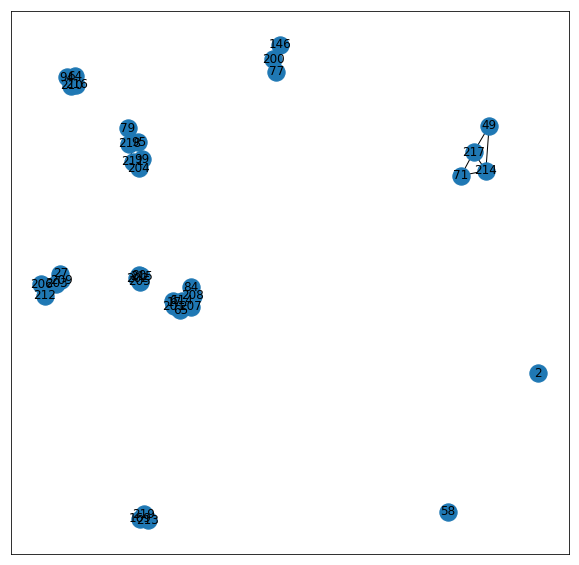

In [9]:
# get the vectors of the first class as example:
import torch
import matplotlib.pyplot as plt
import os
%matplotlib inline
import networkx as nx
plt.figure(figsize=(10, 10))

CLASS = 0
COMPARE_CLASS = None
offset = 200
indication_ids = [2, 6, 17, 27, 49, 58, 64, 65, 71, 77, 79, 80, 84, 94, 95, 99, 114, 146, 169]
num = 20

vectors = torch.load('vectors_sample.tar.gz')
indication_vectors = []
for id in indication_ids:
    indication_vectors.append(vectors[CLASS][id])
vectors = vectors[CLASS][offset : offset + num]
for vector in indication_vectors:
    vectors.append(vector)
vectors = torch.Tensor(vectors)

gdata = []
for i in range(0, len(vectors - 1)):
    # calculate distance between ith sample with all other nodes:
    distances = ((vectors[i] - vectors) ** 2).sum(dim=1)
    topk_value, topk_index = distances.topk(3, sorted=False, largest=False)
    #for j in range(i + 1, len(vectors)):
    #    gdata.append((i, j, distances[j]))
    for j in topk_index:
        if i == j:
            continue
        else:
            if i < num and j.item() < num:
                gdata.append((i + offset, j.item() + offset, distances[j].item()))
            elif i < num and j.item() >= num:
                gdata.append((i + offset, indication_ids[j.item() - num], distances[j].item()))
            elif i >= num and j.item() < num:
                gdata.append((indication_ids[i - num], j.item() + offset, distances[j].item()))
            else:
                gdata.append((indication_ids[i - num], indication_ids[j.item() - num], distances[j].item()))

g = nx.Graph()
g.add_weighted_edges_from(gdata)
bridges = list(nx.bridges(g))
print('The bridges of the graph is: ', bridges)

for edge in bridges:
    g.remove_edge(*edge)
nx.draw_networkx(g)
plt.show()

In [10]:
components = [c for c in nx.connected_components(g)]
th = 10
components_filtered = []
unwanted_components = []
for i, c in enumerate(components):
    if len(c) > th:
        components_filtered.append(c)
    else:
        unwanted_components.append(c)
unwanted_components = sorted(unwanted_components, key=lambda x:len(x))
unwanted_components.reverse()

# visualization of the unwanted data

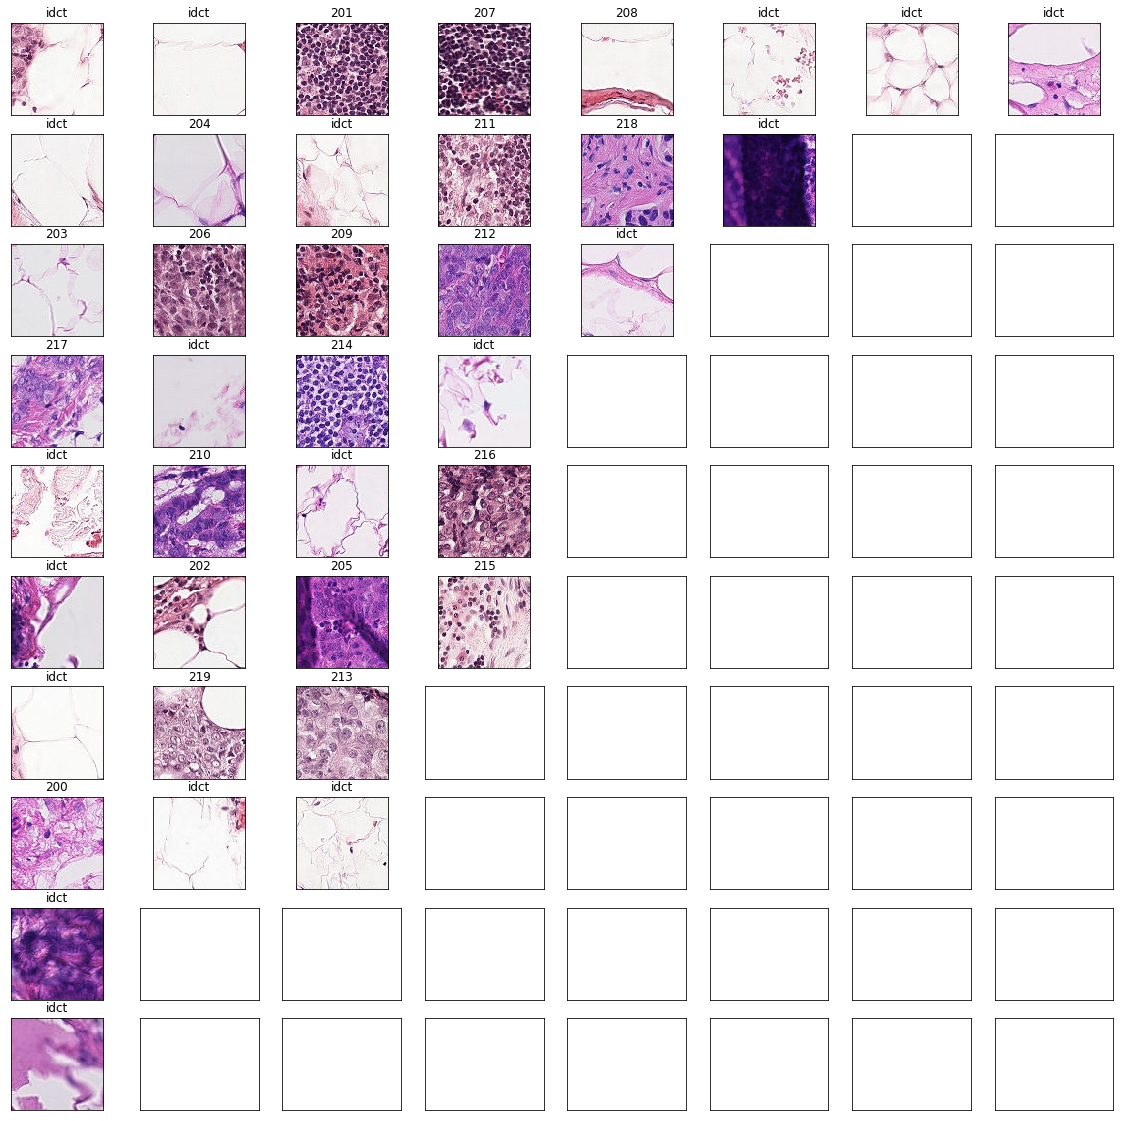

In [11]:
## import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision.transforms import Resize

df = pd.read_csv('../input/train_labels.csv')
df = df[20000:30000]
unwanted_components = [list(c) for c in unwanted_components]
paths = ['../input/train/' + id + '.tif' for id in df['id'].tolist()]
fig, axes = plt.subplots(figsize=(20, 20), nrows=len(unwanted_components), ncols=max(len(i) for i in unwanted_components))
plt.autoscale(tight=True)
for i in range(len(unwanted_components)):
    for j in range(max(len(i) for i in unwanted_components)):
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        axes[i][j].grid(False)
for i in range(len(unwanted_components)):
    for j, idx in enumerate(unwanted_components[i]):
        path = paths[idx]
        img = Image.open(path)
        #axes[i][j].set_xticks([])
        #axes[i][j].set_yticks([])
        if idx in indication_ids:
            axes[i][j].set_title('idct')
        else:
            axes[i][j].set_title(str(idx))
        axes[i][j].imshow(img) if len(unwanted_components) > 1 else axes[j].imshow(img)

# Visualization of normal data

In [12]:

components_filtered = components_filtered[:10]
components_filtered = [list(c) for c in components_filtered]
fig, axes = plt.subplots(figsize=(20, 10), nrows=1, ncols=min(len(components_filtered[0]), 10))

paths = ['../input/train/' + id + '.tif' for id in df['id'].tolist()[:10000]]
for i, ax in enumerate(axes):
    path = paths[components_filtered[0][i]]
    img = Image.open(path)
    ax.imshow(img)

IndexError: list index out of range

In [13]:
# get the vectors of the first class as example:
"""
import torch
import os
import networkx as nx
import math

vectors = torch.load('vectors_sample.tar.gz')
if not COMPARE_CLASS is None:
    vectors = vectors[CLASS][offset : offset + num] + vectors[COMPARE_CLASS][offset : offset + num]
else:
    vectors = vectors[CLASS][offset : offset + num]

vectors = torch.Tensor(vectors)

gdata = []
for i in range(0, len(vectors - 1)):
    # calculate distance between ith sample with all other nodes:
    distances = ((vectors[i] - vectors) ** 2).sum(dim=1)
    topk_value, topk_index = distances.topk(3, sorted=False, largest=False)
    #for j in range(i + 1, len(vectors)):
    #    gdata.append((i, j, distances[j]))
    for j in topk_index:
        if i == j:
            continue
        else:
            gdata.append((i + offset, j.item() + offset, distances[j].item()))

g = nx.Graph()
g.add_weighted_edges_from(gdata)

centrality = nx.algorithms.centrality.degree_centrality(g)
centralities = []
for components in unwanted_components:
    mean_centrality = sum([centrality[i] for i in components]) / (len(components) ** 1.1)
    print(mean_centrality)
    centralities.append(mean_centrality)
print('The mean clustering coificient is: ', sum(centralities) / len(centralities))
plt.hist(centralities, bins=len(ccs))
plt.show()
"""

"\nimport torch\nimport os\nimport networkx as nx\nimport math\n\nvectors = torch.load('vectors_sample.tar.gz')\nif not COMPARE_CLASS is None:\n    vectors = vectors[CLASS][offset : offset + num] + vectors[COMPARE_CLASS][offset : offset + num]\nelse:\n    vectors = vectors[CLASS][offset : offset + num]\n\nvectors = torch.Tensor(vectors)\n\ngdata = []\nfor i in range(0, len(vectors - 1)):\n    # calculate distance between ith sample with all other nodes:\n    distances = ((vectors[i] - vectors) ** 2).sum(dim=1)\n    topk_value, topk_index = distances.topk(3, sorted=False, largest=False)\n    #for j in range(i + 1, len(vectors)):\n    #    gdata.append((i, j, distances[j]))\n    for j in topk_index:\n        if i == j:\n            continue\n        else:\n            gdata.append((i + offset, j.item() + offset, distances[j].item()))\n\ng = nx.Graph()\ng.add_weighted_edges_from(gdata)\n\ncentrality = nx.algorithms.centrality.degree_centrality(g)\ncentralities = []\nfor components in unwa

# Visualization of 200 - 400 images

In [14]:
"""
# assume that the df is available:
import matplotlib.pyplot as plt
import PIL.Image as Image

sub_df = df[200:400]
paths = ['../input/train/' + id + '.tif' for id in sub_df['id'].tolist()]
for i in range(20):
    fig, axes = plt.subplots(figsize=(50, 5), nrows=1, ncols=10)
    for j in range(10):
        img = Image.open(paths[i * 10 + j])
        axes[j].imshow(img)
#all plus 200: 3, 4, 8, 30, 36, 39, 48, 55, 60, 64, 65, 66, 74, 82, 83, 84, 96, 122, 124, 125, 149, 171, 176, 180, 181, 189, 190
"""

"\n# assume that the df is available:\nimport matplotlib.pyplot as plt\nimport PIL.Image as Image\n\nsub_df = df[200:400]\npaths = ['../input/train/' + id + '.tif' for id in sub_df['id'].tolist()]\nfor i in range(20):\n    fig, axes = plt.subplots(figsize=(50, 5), nrows=1, ncols=10)\n    for j in range(10):\n        img = Image.open(paths[i * 10 + j])\n        axes[j].imshow(img)\n#all plus 200: 3, 4, 8, 30, 36, 39, 48, 55, 60, 64, 65, 66, 74, 82, 83, 84, 96, 122, 124, 125, 149, 171, 176, 180, 181, 189, 190\n"

# show the noise data (200 - 400):

In [15]:
"""
import PIL.Image as Image
# noise data ids:
# all plus 200: 3, 4, 8, 30, 36, 39, 48, 55, 60, 64, 65, 66, 74, 82, 83, 84, 96, 122, 124, 125, 149, 171, 176, 180, 181, 189, 190

sub_df = df[200:400]
paths = ['../input/train/' + id + '.tif' for id in df['id'].tolist()]
img = Image.open(paths[347])
img
"""

"\nimport PIL.Image as Image\n# noise data ids:\n# all plus 200: 3, 4, 8, 30, 36, 39, 48, 55, 60, 64, 65, 66, 74, 82, 83, 84, 96, 122, 124, 125, 149, 171, 176, 180, 181, 189, 190\n\nsub_df = df[200:400]\npaths = ['../input/train/' + id + '.tif' for id in df['id'].tolist()]\nimg = Image.open(paths[347])\nimg\n"

# get the true labels of the 200 - 400 samples of the df

In [16]:
# documentation of disqualified data:
import numpy as np

true_labels = list(np.zeros(200).astype(np.int32))
noise_ids = [0, 3, 4, 8, 30, 36, 39, 41, 44, 47, 48, 55, 60, 64, 65, 66, 74, 82, 83, 84, 96, 122, 124, 125, 149, 171, 176, 180, 181, 189, 190]
for id in noise_ids:
    true_labels[id] = 1
print(true_labels)

[1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# F1 score and accuracy score calculation (Our method):

In [17]:
# Our method first 20 samples:
from sklearn.metrics import f1_score, accuracy_score

noise = [202, 205, 214, 215, 217, 201, 208, 211, 204, 206, 207, 219, 212, 216, 200, 213, 218, 210, ]
pred_labels = list(np.zeros(num).astype(np.int32))
for id in noise:
    pred_labels[id - 200] = 1
score = f1_score(true_labels[:num], pred_labels)
acc = accuracy_score(true_labels[:num], pred_labels)
print('The f1 score is: ', score)
print('The accuracy is: ', acc)

The f1 score is:  0.27272727272727276
The accuracy is:  0.2


# Calculate accuracy and F1 score over different proportion of noise data:

/opt/conda/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/opt/conda/lib/python3.6/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  n_init=n_init)


[2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


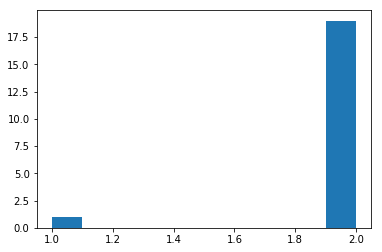

In [18]:
# do the clustering and detect the outliers:
from sklearn.cluster import OPTICS, DBSCAN, SpectralClustering
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt

vectors = torch.load('vectors_sample.tar.gz')
vectors = vectors[CLASS][offset : offset + num]
vectors = torch.Tensor(vectors)

y_pred = list(OPTICS().fit_predict(vectors))
y_pred = list(SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1,
          degree=2, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=10, n_init=10, n_jobs=None,
          n_neighbors=3, random_state=0).fit_predict(vectors))
#for i in range(len(y_pred)):
#    if y_pred[i] == 4 or y_pred[i] == 3:
#        y_pred[i] = 1
#    else:
#        y_pred[i] = 0
print(y_pred)
plt.hist(y_pred)
plt.show()

In [19]:
from sklearn.metrics import f1_score, accuracy_score

noise = [213, 219]
#pred_labels = list(np.zeros(20).astype(np.int32))
#for id in noise:
#    pred_labels[id - 200] = 1
score = f1_score(true_labels[:num], y_pred)
acc = accuracy_score(true_labels[:num], y_pred)
print('The f1 score is: ', score)
print('The accuracy is: ', acc)

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

# Record of the Score of different proportion of label flip

In [20]:
"""
10%:
The f1 score is:  0.6551724137931035
The accuracy is:  0.9

15%:
The f1 score is:  0.5714285714285714
The accuracy is:  0.895

20%:
The f1 score is:  0.6666666666666666
The accuracy is:  0.9

25%:
The f1 score is:  0.6666666666666666
The accuracy is:  0.9

30%:
The f1 score is:  0.6153846153846153
The accuracy is:  0.75
"""

'\n10%:\nThe f1 score is:  0.6551724137931035\nThe accuracy is:  0.9\n\n15%:\nThe f1 score is:  0.5714285714285714\nThe accuracy is:  0.895\n\n20%:\nThe f1 score is:  0.6666666666666666\nThe accuracy is:  0.9\n\n25%:\nThe f1 score is:  0.6666666666666666\nThe accuracy is:  0.9\n\n30%:\nThe f1 score is:  0.6153846153846153\nThe accuracy is:  0.75\n'